# Improving WW3 predction with Machine Learning

First, install the requirements:

```bash
# create a new environment
conda create --name tf python=3.7
# activate your new environment
conda activate tf

# install tensorflow CPU version
conda install tensorflow=2
conda install tensorboard

# If you have a NVIDIA GPU installed and properly configured
conda install tensorflow-gpu=2
conda install tensorboard

# Natsort - better file sorting
conda install natsort

# Data I/O
import xarray as xr

# Classical machine learning
conda install pandas scikit-learn scikit-image

# Matplotlib and seaborn
conda install matplotlib seaborn

# plot your models
conda install pydot graphviz

# make your life easier with ipython
conda install ipython
```

# 3 - Improving wave direction using the whole spectrum

In this second example, the model is trained with the full spectral information.

The target is still the measured wave direction.

The main diference from the previous example is that now we look at where the energy is in the spectrum as well as how much energy there is.

**WARNING: This example is to heavy to train on CPU - we recomend at least a GTX1080** 

## 3.1 Import the packages

In [1]:
import os

import datetime

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, Dropout,
                                     MaxPooling2D, Flatten, Input)
from tensorflow.keras.optimizers import Adam

from joblib import dump, load

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1.25, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {"axes.linewidth": 2,
                        "legend.frameon": True,
                        "axes.facecolor": "#E9E9F1",
                        "grid.color": "w"})
mpl.rcParams["axes.linewidth"] = 2

## 3.2 - Define hyperparameters for the model

In [2]:
# Hyperparameters
TEST_SIZE = 0.3  # Fraction of data to use as test
RANDOM_STATE = 42  # State for reproducibility
MODEL = "CNN"  # Model name
STRATIFY = True  # make sure to use balanced dataset
LEARNING_RATE = 0.0001
EPOCHS = 64  # Number of epochs to train the model
DROPOUT = 0.25  # Dropout rate between layers
TRAIN = False
BATCH_SIZE = 2014

# try to load a previous model
if os.path.isfile("{}.h5".format(MODEL)):
    previous_model = True
    model = load_model("{}.h5".format(MODEL))
    print("Model loaded!")
else:
    previous_model = False
# try to load the history
if os.path.isfile("{}_history.csv".format(MODEL)):
    previous_model = True
    hist = pd.read_csv("{}_history.csv".format(MODEL))
    print("History loaded!")
else:
    history = False
if os.path.isfile("{}_xscaler.dat".format(MODEL)):
    previous_scaler = True
    xscaler = load("{}_xscaler.dat".format(MODEL))
    print("Scaler loaded!")
else:
    previous_scaler = False

Model loaded!
History loaded!
Scaler loaded!


## 3.3 - Load data

Colmuns ```769``` and ```771``` contain the observed and modelled direction data, column ```773``` contains the locations' ID, and columns from ```0``` to ```769``` are the spectral data.

In [3]:
# load the daaset
DATA = "spectral_data.csv"
inp = pd.read_csv(DATA, delimiter=",", header=None)
df = inp.iloc[:, -5:]  # these are the scalar variables
ds = inp.iloc[:, 1:-5]  # this are the training data

# covert Dm_obs and Dm_mod to radians so that it is a continous
# variable between -pi and pi

df["Dm_mod_rad"] = np.deg2rad(df[769]) - np.pi
df["Dm_obs_rad"] = np.deg2rad(df[771]) - np.pi
df["Dm_mod_angles"] = df[769]
df["Dm_obs_angles"] = df[771]

# compute the sin a cos, these are the target variables

df["Dm_mod_sinx"] = np.sin(df["Dm_mod_rad"])
df["Dm_mod_cosx"] = np.cos(df["Dm_mod_rad"])

df["Dm_obs_sinx"] = np.sin(df["Dm_obs_rad"])
df["Dm_obs_cosx"] = np.cos(df["Dm_obs_rad"])

In [4]:
# get the dates from the dataframe with integrated parameters
df["Time_UTC"] = pd.read_csv("integrated_parameters.csv")["Time_UTC"]

## 3.4 - Prepare the training, testing and validation datasets

The biggest advantage here is that there is no need to define features to learn from. All the information we need is already in the spectrum.

In [5]:
X = ds.values

# prepare output array - Buoy data
y = df[["Dm_obs_sinx", "Dm_obs_cosx"]].values

# convert ID to int in order to preserve class PDF
# when doing the train/test split
df["ID"] = df[773]
if STRATIFY:
    df["labels"] = pd.factorize(df["ID"])[0].astype(np.uint16)
    labels = df["labels"].values
else:
    labels = np.ones(y.shape)

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE,
    shuffle=None)

# split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, shuffle=True)

In [6]:
print("There are {} training samples, {} validation samples, and {} testing samples".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

There are 25395 training samples, 10884 validation samples, and 15549 testing samples


In [7]:
# scale data 0-1 interval
if previous_scaler:
    X_train = xscaler.transform(X_train)
    X_test = xscaler.transform(X_test)
    X_val = xscaler.transform(X_val)
    X_all = xscaler.transform(X)
else:
    xscaler = MinMaxScaler().fit(X_train)
    X_train = xscaler.transform(X_train)
    X_test = xscaler.transform(X_test)
    X_val = xscaler.transform(X_val)
    X_all = xscaler.transform(X)
    # save the scaler for later usage
    dump(xscaler, "{}_xscaler.dat".format(MODEL))

# 3.5 - Reshape the spectrum

This a very important step. We need to reshape the data so that it is the the shape that Conv2D likes.

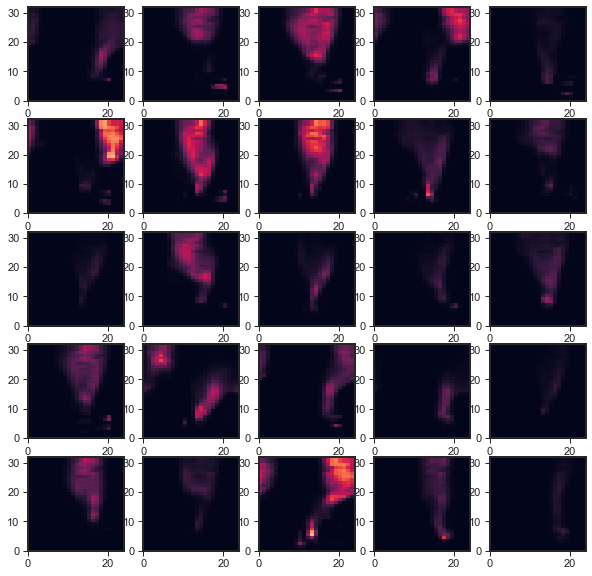

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 24, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 24, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 24, 1)

fig, ax = plt.subplots(5, 5, figsize=(10,10))
axs = ax.flatten()
k = 0
for i in np.linspace(0, len(X_val)-1, 5*5).astype(int):
    axs[k].pcolormesh(np.squeeze(X_val[i, :, :, :]), vmin=0, vmax=1)
    k += 1

plt.show()

## 3.6 - Define the Model

In [9]:
if previous_model:
    model.summary()
else:
    # function for creating a vgg block - Thanks Machine Learning Mastery
    def vgg_block(layer_in, n_filters, n_conv):
        # add convolutional layers
        for _ in range(n_conv):
            layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
        # add max pooling layer
        layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
        layer_in = Dropout(DROPOUT)(layer_in)

        return layer_in

    # define model input
    visible = Input(shape=(32, 24, 1))
    # add vgg module
    layer = vgg_block(visible, 64, 2)
    # add vgg module
    layer = vgg_block(layer, 128, 2)
    # add vgg module
    layer = vgg_block(layer, 256, 4)

    # flatten
    flat = Flatten()(layer)
    fcn1 = Dense(1024)(flat)
    drop1 = Dropout(DROPOUT)(fcn1)
    fcn2 = Dense(1024)(drop1)
    drop2 = Dropout(DROPOUT)(fcn2)
    fcn3 = Dense(2)(drop2)

    # create model
    model = Model(inputs=visible, outputs=fcn3)

    # compile
    optimizer = Adam(learning_rate=float(LEARNING_RATE))
    model.compile(optimizer=optimizer,
                  loss="mse",
                  metrics=["mse"])

    model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 24, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 24, 64)        640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 12, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 12, 128)       73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 12, 128)       1475

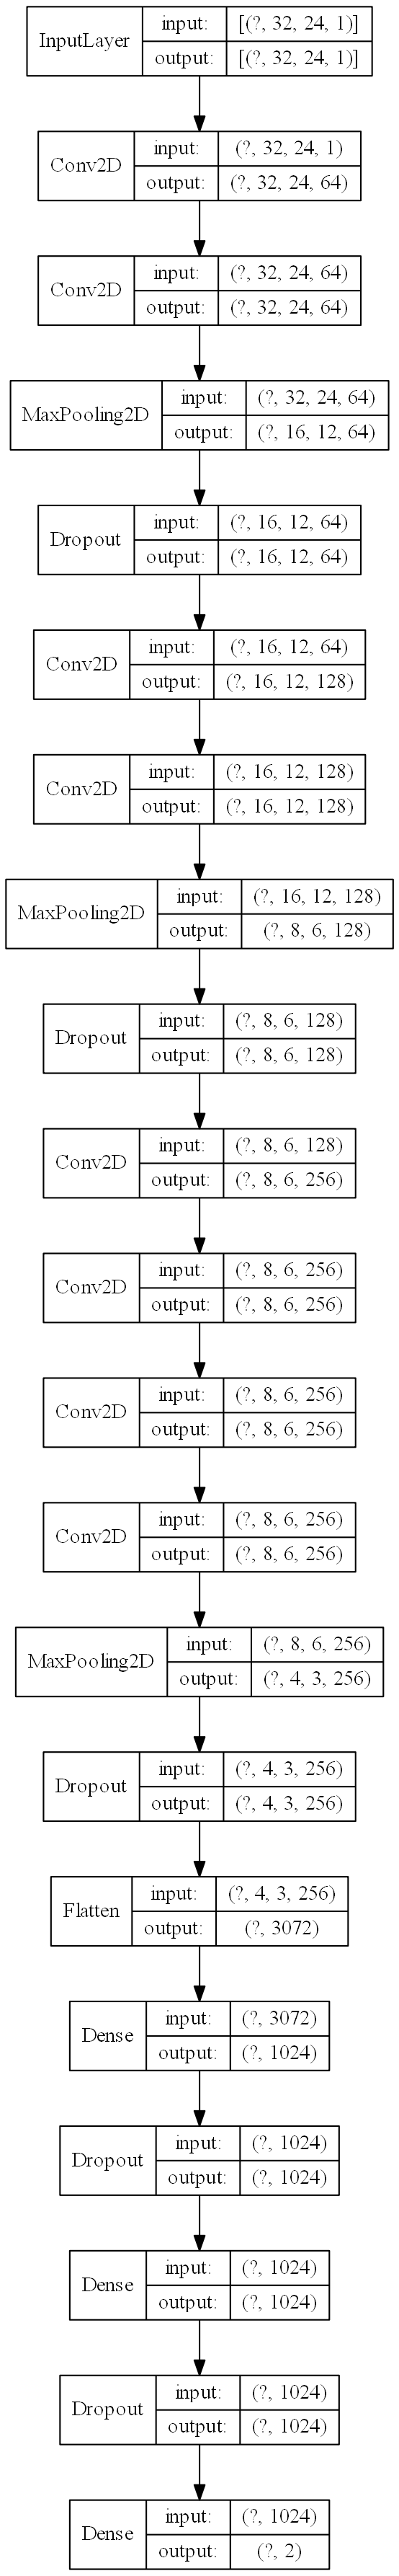

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='arc_cnn_spc.png', show_shapes=True, rankdir='TD', expand_nested=False, show_layer_names=False, dpi=150)

## 3.7 - Train the model

In [32]:
if TRAIN:
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(X_val, y_val))
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    hist.to_csv("{}_history.csv".format(MODEL))
else:
    print("Not training the model.")
        

Not training the model.


In [33]:
# save model to file
if TRAIN:
    print("\n - Saving trained model to file")
    model.save("{}.h5".format(MODEL))

In [34]:
# predict
y_pred = np.squeeze(model.predict(X_test))

# convert back to radians
y_pred_rescaled = np.arctan2(y_pred[:, 0], y_pred[:, 1])
y_test_rescaled = np.arctan2(y_test[:, 0], y_test[:, 1])

print("\n - Results (in radians)")
print("\n   WW3")
ww3_r2 = r2_score(df["Dm_mod_rad"].values,
                  df["Dm_obs_rad"].values)
print("     r2-score:", round(ww3_r2, 2))
ww3_rmse = np.sqrt(mean_squared_error(df["Dm_mod_rad"].values,
                                      df["Dm_obs_rad"].values))
print("     rmse:", round(ww3_rmse, 2))
ww3_mae = mean_absolute_error(df["Dm_mod_rad"].values,
                              df["Dm_obs_rad"].values)
print("     mae", round(ww3_mae, 2))

print("\n   MLP")
mlp_r2 = r2_score(y_pred_rescaled, y_test_rescaled)
print("     r2-score:", round(mlp_r2, 2))
mlp_rmse = np.sqrt(mean_squared_error(y_pred_rescaled,
                                      y_test_rescaled))
print("     rmse:", round(mlp_rmse, 2))
mlp_mae = mean_absolute_error(y_pred_rescaled, y_test_rescaled)
print("     mae", round(mlp_mae, 2))

# apply the transformation to all data
X_all = xscaler.transform(X)
X_all = X_all.reshape(X_all.shape[0], 32, 24, 1)
y_pred_all = np.squeeze(model.predict(X_all))
y_pred_radians = np.squeeze(np.arctan2(y_pred_all[:, 0], y_pred_all[:, 1]))
y_pred_angles = np.rad2deg(y_pred_radians + np.pi)
df["prediction"] = y_pred_angles


 - Results (in radians)

   WW3
     r2-score: 0.04
     rmse: 0.31
     mae 0.24

   MLP
     r2-score: 0.93
     rmse: 0.1
     mae 0.08


## 3.8 -  Plot Regressions

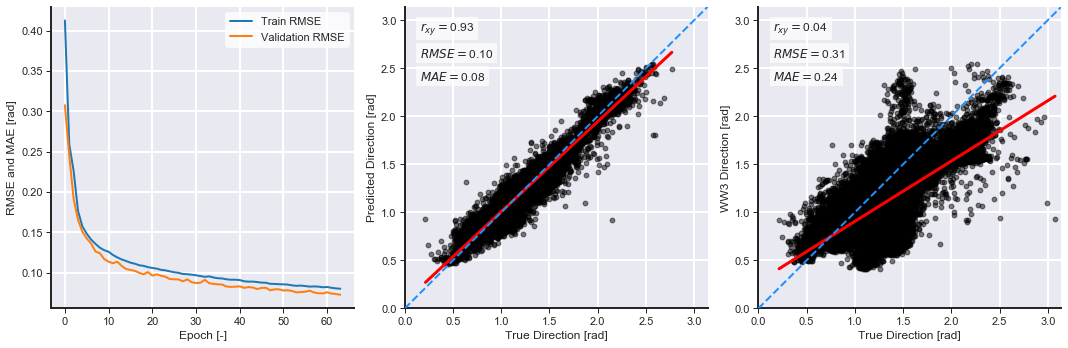

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

try:
    ax1.plot(hist["epoch"], np.sqrt(hist["mse"]), label="Train RMSE")
    ax1.plot(hist["epoch"], np.sqrt(hist["val_mse"]), label="Validation RMSE")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("RMSE [rad]")
except Exception:
    print("No training history was recorded")

lg = ax1.legend()
lg.get_frame().set_color("w")

ax1.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax1)

ax1.set_ylabel("RMSE and MAE [rad]")
ax1.set_xlabel("Epoch [-]")

sns.regplot(y_test_rescaled, y_pred_rescaled, ax=ax2, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax2.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax2.set_xlabel("True Direction [rad]")
ax2.set_ylabel("Predicted Direction [rad]")

ax2.set_xlim(0, 3.14)
ax2.set_ylim(0, 3.14)

ax2.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax2)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(mlp_r2)
ax2.text(0.05, 0.9, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(mlp_rmse)
ax2.text(0.05, 0.825, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(mlp_mae)
ax2.text(0.05, 0.75, txt, transform=ax2.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

# plot WW3 results
y_ww3_rescaled = np.arctan2(df["Dm_mod_sinx"].values,
                            df["Dm_mod_cosx"].values)
y_obs_rescaled = np.arctan2(df["Dm_obs_sinx"].values,
                            df["Dm_obs_cosx"].values)
sns.regplot(y_obs_rescaled, y_ww3_rescaled, ax=ax3, truncate=True,
            color="r", scatter_kws={"color": "k", "alpha": 0.5})
ax3.plot((0, 10), (0, 10), color="dodgerblue", ls="--", lw=2, zorder=10)

ax3.set_xlim(0, 3.14)
ax3.set_ylim(0, 3.14)

ax3.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax3)

bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
txt = r"$r_{xy}=$"+"{0:.2f}".format(ww3_r2)
ax3.text(0.05, 0.9, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$RMSE=$"+"{0:.2f}".format(ww3_rmse)
ax3.text(0.05, 0.825, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)
txt = r"$MAE=$"+"{0:.2f}".format(ww3_mae)
ax3.text(0.05, 0.75, txt, transform=ax3.transAxes, ha="left",
         va="bottom", bbox=bbox, zorder=100)

ax3.set_xlabel("True Direction [rad]")
ax3.set_ylabel("WW3 Direction [rad]")

# finalyse
fig.tight_layout()
plt.show()

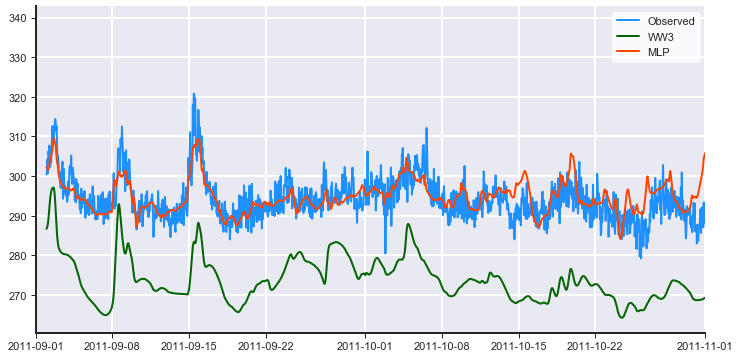

In [39]:
dfl = df.loc[df["ID"] == "ALebu"]
fig, ax = plt.subplots(figsize=(12, 6))

x = pd.to_datetime(dfl["Time_UTC"].values).to_pydatetime()
ytrue = dfl["Dm_obs_angles"].values
ymod =  dfl["Dm_mod_angles"].values
ymlp = dfl["prediction"].values

ax.plot(x, ytrue, color="dodgerblue", label="Observed")
ax.plot(x, ymod, color="darkgreen", label="WW3")
ax.plot(x, ymlp, color="orangered", label="MLP")

ax.grid(color="w", ls="-", lw=2)
sns.despine(ax=ax)

lg = ax.legend(loc=1)
lg.get_frame().set_color("w")

ax.set_xlim(datetime.datetime(2011, 9, 1), datetime.datetime(2011, 11, 1))

plt.show()

In [40]:
df.to_csv("CNN_PREDICTIONS.csv")